In [1]:
import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re

**Discounted Purchase**

In [28]:
query3 = """with initial_dataset as (
  select
    event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialVie','sv__OnBoardingTutorialVi','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','sv__AAPageA','sv__ProPageA','sv_GoldPageA','sv__AAPageF','sv__ProPageF','sv__GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraph','PlayNextParagraphFromBut','sv__OnBoardingTutorialVie','in_app_purchase','PurchaseNormal')
),

onboarding as (
  select distinct
    'onboarding' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as onboarding_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as onboarding_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('sv__OnBoardingTutorialVi','sv__OnBoardingTutorialVie')
),

purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),

relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    purchases as pur on pur.user_pseudo_id = ini.user_pseudo_id
  left join
    onboarding as onb on onb.user_pseudo_id = ini.user_pseudo_id
  where
    ini.event_name not in ('in_app_purchase','PurchaseNormal','sv__OnBoardingTutorialVi','sv__OnBoardingTutorialVie')
  and
    ini.event_timestamp between onb.onboarding_timestamp and timestamp_add(onb.onboarding_timestamp, interval 7 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    purchases as rep
  left join
    onboarding as onb on onb.user_pseudo_id = rep.user_pseudo_id
  where
    rep.first_purchase_timestamp between onb.onboarding_timestamp and timestamp_add(onb.onboarding_timestamp, interval 7 day)
)

select
  user_pseudo_id,
  event_name,
  platform,
  country,
  device_language,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2,3,4,5;"""

df3 = pandas_gbq.read_gbq(query3, project_id= 'beelinguapp')

In [29]:
df3.event_name.value_counts()

sv__Libraries                109923
ClickOnWholeView              71545
sv__WelcomeCarouselDialog     64251
StartListening                62791
sv__StoryDetails              57467
StartNStory                   55909
LibraryClicked                24747
sv__NewPremiumAct             17093
sv__AAPageA                    9777
PremiumBarClickedMain          9567
sv__ProPageA                   7211
sv__AAPageF                    6320
StartBekids                    6315
PlayNextParagraphFromBut       6312
sv__GlossaryF                  5612
sv__ProPageF                   4883
PremiumBarClickedSD            4376
FabClickedPremium              2516
EnterFcMore                    2325
TryToBuyNewPAct                2052
sv__GoldPageF                  1949
in_app_purchase                 896
TryToBuyNewPF                   713
PlayPrevParagraph               186
Name: event_name, dtype: int64

In [30]:
df3.head()

,user_pseudo_id,event_name,platform,country,device_language,occurrences_count,first_event_timestamp,last_event_timestamp
0,27918664CB944EF2963F1C03F1FDDF06,in_app_purchase,IOS,Mexico,en-de,1,2020-12-08 13:26:15.811000+00:00,2020-12-08 13:26:15.811000+00:00
1,1F09A73AEC464541B3547F9B41AF1EFE,in_app_purchase,IOS,Guatemala,es-gt,1,2020-11-19 23:50:05.118000+00:00,2020-11-19 23:50:05.118000+00:00
2,8371132fe66bb3326711366dee8513b2,sv__ProPageA,ANDROID,Malaysia,zh-my,2,2020-11-24 06:47:24.718013+00:00,2020-11-24 06:47:31.151019+00:00
3,fbc0eb2a0e2add8efe5e62ab69cc9988,FabClickedPremium,ANDROID,Philippines,en-ph,2,2020-11-24 17:12:57.502000+00:00,2020-11-24 17:12:58.013000+00:00
4,8c1f00b9aee2d296855ab7f05315c14f,sv__WelcomeCarouselDialog,ANDROID,Thailand,th-th,1,2020-11-24 09:19:02.375003+00:00,2020-11-24 09:19:02.375003+00:00


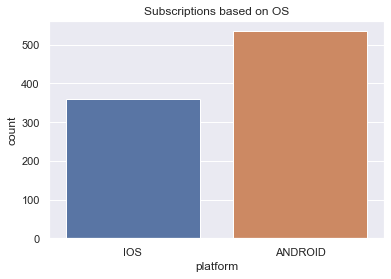

In [31]:
sns.set_theme(style="darkgrid")
sns.countplot(x='platform',data=df3[df3.event_name=='in_app_purchase'])
plt.title('Subscriptions based on OS')
plt.show()
# indicate in_app_purchases based on different OS

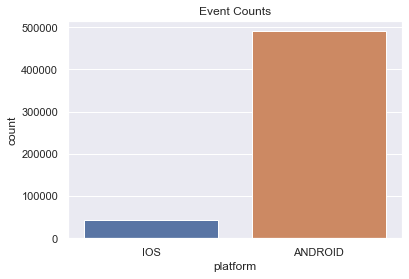

In [109]:
sns.set_theme(style="darkgrid")
sns.countplot(x='platform',data=df3)
plt.title('Event Counts')
plt.show()
# indicate in_app_purchases based on different OS

In [49]:
df_log = df3.pivot_table(index=["user_pseudo_id","platform"],columns=["event_name"],fill_value=0)
# getting the events_occurences aggregated in user_pseudo_level

In [110]:
df_log.head()

event_name,user_pseudo_id,platform,ClickOnWholeView,EnterFcMore,FabClickedPremium,LibraryClicked,PlayNextParagraphFromBut,PlayPrevParagraph,PremiumBarClickedMain,PremiumBarClickedSD,...,sv__GlossaryF,sv__GoldPageF,sv__Libraries,sv__NewPremiumAct,sv__ProPageA,sv__ProPageF,sv__StoryDetails,sv__WelcomeCarouselDialog,Android,IOS
0,0000892c8eff256f940b90c82d8c6d23,ANDROID,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0,2.0,0.0,0.0,0.0,0.0,1.0,1,0
1,0000A66B622A444CB30AE962D12A5F4A,IOS,1.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,0000bf6a4004cd40d8f190bee72aa98e,ANDROID,3.0,0,0,0.0,5.0,0,0.0,0.0,...,0.0,0,5.0,0.0,0.0,0.0,5.0,1.0,1,0
3,0000d2213ba1e2c0d3d6221e8f092888,ANDROID,1.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0,3.0,0.0,0.0,0.0,1.0,2.0,1,0
4,00012abfde7c6b3a0c103d443377e47a,ANDROID,2.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0,4.0,0.0,0.0,0.0,2.0,0.0,1,0


In [50]:
df_log.columns = df_log.columns.droplevel()
# flattening the columns

df_log.reset_index(inplace=True)
# converting user_pseudo_id as a column

In [55]:
df_log[["Android","IOS"]] = pd.get_dummies(df_log["platform"])

In [41]:
df_log["platform"] = np.where(df_log["platform"]=="ANDROID",1,0)

In [56]:
df_log.head()

event_name,user_pseudo_id,platform,ClickOnWholeView,EnterFcMore,FabClickedPremium,LibraryClicked,PlayNextParagraphFromBut,PlayPrevParagraph,PremiumBarClickedMain,PremiumBarClickedSD,...,sv__GlossaryF,sv__GoldPageF,sv__Libraries,sv__NewPremiumAct,sv__ProPageA,sv__ProPageF,sv__StoryDetails,sv__WelcomeCarouselDialog,Android,IOS
0,0000892c8eff256f940b90c82d8c6d23,ANDROID,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0,2.0,0.0,0.0,0.0,0.0,1.0,1,0
1,0000A66B622A444CB30AE962D12A5F4A,IOS,1.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,0000bf6a4004cd40d8f190bee72aa98e,ANDROID,3.0,0,0,0.0,5.0,0,0.0,0.0,...,0.0,0,5.0,0.0,0.0,0.0,5.0,1.0,1,0
3,0000d2213ba1e2c0d3d6221e8f092888,ANDROID,1.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0,3.0,0.0,0.0,0.0,1.0,2.0,1,0
4,00012abfde7c6b3a0c103d443377e47a,ANDROID,2.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0,4.0,0.0,0.0,0.0,2.0,0.0,1,0


In [42]:
df_log['in_app_purchase'].value_counts()
#there are 2 event occurences in_app_purchases

0    123000
1       871
2        25
Name: in_app_purchase, dtype: int64

In [12]:
df3[(df3.event_name=='in_app_purchase') & (df3.occurrences_count > 1)]['user_pseudo_id']
#users who purchased more than 1

2       cef9669108b7a0a7fa0cf1a7dfff690e
615     e9aaf33848e3975412faa35cb045402f
813     5eb513e3c4e756fb92f60eac010ca06b
1231    79f1cffaac45038fbbf89b916dc23a33
1835    bb8ed38469fd54dbe18b53791ba32252
2214    49c52b3bbecb4ef9175334d49521305d
3838    676ea6dab4ecccbc13601b0249ab7eaf
4058    1b2f1c44887e098e548c96ad238b681f
4819    9a0068bc1c4334fa89a662d19e94fefa
4820    c640ee57c85c02c4558acb2a7e3d808f
5218    f40a7ea0dd2047a31ef9a8fa853c6495
5626    302b79e4b11838bf31158e93470d0d99
6044    44c020e61ac7f3b03eb47ecfb455d2d1
6276    acac635466bba294060d6e5743bbb219
6473    f768bb55076b14d51a52b709ff09a839
7099    eb6d2033f9ba8f385008d6468bd38376
7303    ecf081dd7776bc0a2df3cee5a37c7e8e
7725    5ac14e26eb62ec5228eeecc78c7dcae2
7928    5d82a65f4bcbe4ffdda679c5e2d73066
8559    0ea1c66a9d89f8f654e5ecea7a852d67
8564    65558773e5bc64125958f1f063f065b0
8789    162f774dd2dcb9c5ab35d449cc31cebe
8999    6cdb3961c2103798c8291ef59748a750
9190    2d3cea5fc4362e7b6fd26b43d93bc284
9608    69901a29

In [57]:
df_log['in_app_purchase'] = np.where(df_log['in_app_purchase']>0,1,0)
#converting in_app_purchase as binary

In [58]:
df_log['in_app_purchase'].value_counts()
#checking the value counts again

0    123000
1       896
Name: in_app_purchase, dtype: int64

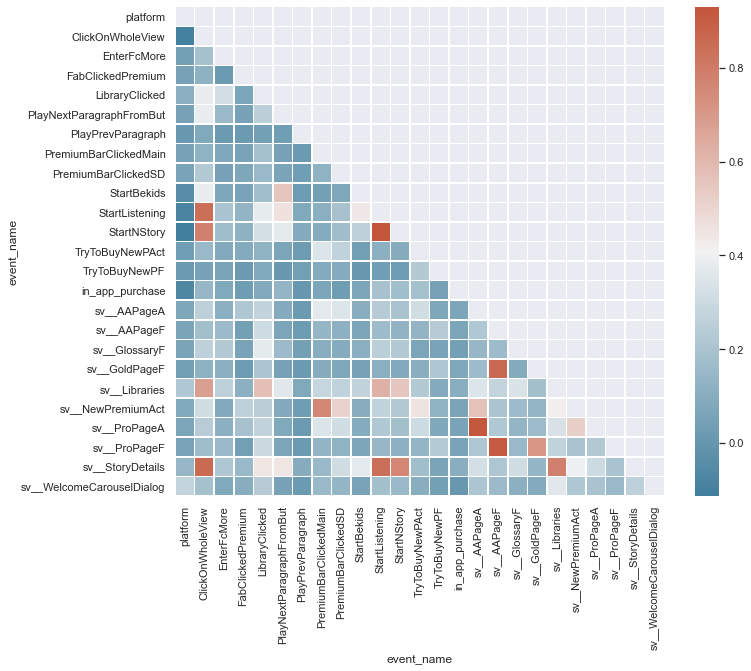

In [45]:
corr = df_log.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool)) # removing the other side of the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,linewidths=.5,square=True)
plt.show()
#there is no really correlated events with in_app_purchase

In [68]:
df3[(df3.event_name=="sv__WelcomeCarouselDialog") & (df3.occurrences_count>5)]["country"].value_counts()

India            97
Mexico           43
Brazil           33
Turkey           18
United States    16
                 ..
Jordan            1
Austria           1
Belgium           1
Luxembourg        1
Portugal          1
Name: country, Length: 65, dtype: int64

In [61]:
cols = ['ClickOnWholeView',
 'EnterFcMore',
 'FabClickedPremium',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'PremiumBarClickedMain',
 'PremiumBarClickedSD',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'TryToBuyNewPAct',
 'TryToBuyNewPF',
'sv__AAPageA',
 'sv__AAPageF',
 'sv__GlossaryF',
 'sv__GoldPageF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__ProPageA',
 'sv__ProPageF',
 'sv__StoryDetails',
 'sv__WelcomeCarouselDialog',
       "IOS"]

In [99]:
y = df_log['in_app_purchase']
X = df_log[cols]
X = sm.add_constant(X)
model1 = sm.Logit(y, X).fit()
res = model1.summary()
print(res)

Optimization terminated successfully.
         Current function value: 0.032144
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:        in_app_purchase   No. Observations:               123896
Model:                          Logit   Df Residuals:                   123871
Method:                           MLE   Df Model:                           24
Date:                Sat, 12 Dec 2020   Pseudo R-squ.:                  0.2499
Time:                        12:52:15   Log-Likelihood:                -3982.5
converged:                       True   LL-Null:                       -5309.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.9656      0.067    -88.861      0.000      -6

**Model 2 only for Android Users with 30 mins**

In [113]:
cols2 = ['ClickOnWholeView',
 'EnterFcMore',
 'FabClickedPremium',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'PremiumBarClickedMain',
 'PremiumBarClickedSD',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'TryToBuyNewPAct',
 'TryToBuyNewPF',
'sv__AAPageA',
 'sv__AAPageF',
 'sv__GlossaryF',
 'sv__GoldPageF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__ProPageA',
 'sv__ProPageF',
 'sv__StoryDetails',
 'sv__WelcomeCarouselDialog']

In [115]:
y = df_log[df_log.platform=="ANDROID"]['in_app_purchase']
X = df_log[df_log.platform=="ANDROID"][cols2]
X = sm.add_constant(X)
model2 = sm.Logit(y, X).fit()
res = model2.summary()
print(res)

Optimization terminated successfully.
         Current function value: 0.022337
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:        in_app_purchase   No. Observations:               108382
Model:                          Logit   Df Residuals:                   108358
Method:                           MLE   Df Model:                           23
Date:                Sat, 12 Dec 2020   Pseudo R-squ.:                  0.2827
Time:                        14:04:45   Log-Likelihood:                -2420.9
converged:                       True   LL-Null:                       -3375.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.9840      0.069    -86.352      0.000      -6

In [23]:
df_log[df_log.platform=="IOS"]["sv__WelcomeCarouselDialog"].sum()

0

**non_discounted purchase**

In [76]:
query="""with initial_dataset as (
  select
    case 
      when event_name like 'sv__OnBoardingTutorialVi%' then 'sv__OnBoardingTutorialView'
      else event_name
    end as event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialVi','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','sv__AAPageA','sv__ProPageA','sv_GoldPageA','sv__AAPageF','sv__ProPageF','sv__GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraph','PlayNextParagraphFromBut','sv__OnBoardingTutorialVie','in_app_purchase','PurchaseNormal')
),   

premium_promo_shown as (
  select distinct
    user_pseudo_id,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_premium_promo_shown_timestamp
  from
    initial_dataset
  where
    event_name = 'sv__WelcomeCarouselDialog'
),

purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),

relevant_purchases as (
  select
    pu.event_name,
    pu.first_purchase_timestamp,
    pu.first_purchase_date,
    ps.first_premium_promo_shown_timestamp,
    pu.optional_label,
    pu.user_id,
    pu.user_pseudo_id,
    pu.ga_session_id,
    pu.user_history_event_number,
    pu.session_event_number,
    pu.platform,
    pu.device_language,
    pu.country
  from
    purchases as pu
  join
    premium_promo_shown as ps on ps.user_pseudo_id = pu.user_pseudo_id
  where
    pu.first_purchase_timestamp > timestamp_add(ps.first_premium_promo_shown_timestamp, interval 30 minute)
),

relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    premium_promo_shown as ps on ps.user_pseudo_id = ini.user_pseudo_id
  where
    event_name != 'in_app_purchase'
  and
    ini.event_timestamp between ps.first_premium_promo_shown_timestamp and timestamp_add(first_premium_promo_shown_timestamp, interval 7 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    relevant_purchases as rep
  where
    rep.first_purchase_timestamp between rep.first_premium_promo_shown_timestamp and timestamp_add(rep.first_premium_promo_shown_timestamp, interval 7 day)
)

select
  user_pseudo_id,
  event_name,
  platform,
  country,
  device_language,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2,3,4,5;
"""

df = pandas_gbq.read_gbq(query, project_id= 'beelinguapp')

In [79]:
df.event_name.value_counts()

sv__WelcomeCarouselDialog     65952
sv__Libraries                 62153
sv__StoryDetails              50518
ClickOnWholeView              49966
StartListening                44135
StartNStory                   38395
LibraryClicked                21211
sv__NewPremiumAct             16859
sv__AAPageA                    9685
PremiumBarClickedMain          9597
sv__ProPageA                   7146
sv__AAPageF                    6305
sv__ProPageF                   4881
sv__GlossaryF                  4808
PlayNextParagraphFromBut       4257
StartBekids                    4254
PremiumBarClickedSD            4191
FabClickedPremium              2499
TryToBuyNewPAct                2046
sv__GoldPageF                  1942
EnterFcMore                    1741
TryToBuyNewPF                   718
sv__OnBoardingTutorialView      237
PlayPrevParagraph               166
in_app_purchase                  65
Name: event_name, dtype: int64

In [80]:
df.event_name.nunique()

25

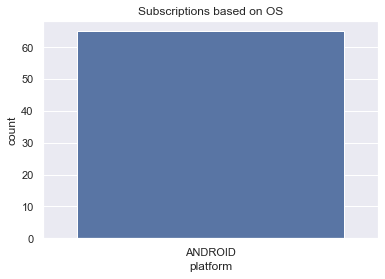

In [81]:
sns.set_theme(style="darkgrid")
sns.countplot(x='platform',data=df[df.event_name=='in_app_purchase'])
plt.title('Subscriptions based on OS')
plt.show()
# indicate in_app_purchases based on different OS
#there is only android

In [84]:
df_log2 = df.pivot_table(index=["user_pseudo_id"],columns=["event_name"],fill_value=0)

In [86]:
df_log2.columns = df_log2.columns.droplevel()
# flattening the columns

df_log2.reset_index(inplace=True)
# converting user_pseudo_id as a column

In [87]:
df_log2.head()

event_name,user_pseudo_id,ClickOnWholeView,EnterFcMore,FabClickedPremium,LibraryClicked,PlayNextParagraphFromBut,PlayPrevParagraph,PremiumBarClickedMain,PremiumBarClickedSD,StartBekids,...,sv__AAPageF,sv__GlossaryF,sv__GoldPageF,sv__Libraries,sv__NewPremiumAct,sv__OnBoardingTutorialView,sv__ProPageA,sv__ProPageF,sv__StoryDetails,sv__WelcomeCarouselDialog
0,0000892c8eff256f940b90c82d8c6d23,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,1.0,0.0,0,0.0,0.0,0.0,1.0
1,0000bf6a4004cd40d8f190bee72aa98e,3.0,0,0,0.0,5.0,0,0.0,0.0,1.0,...,0.0,0.0,0,3.0,0.0,0,0.0,0.0,5.0,1.0
2,0000d2213ba1e2c0d3d6221e8f092888,1.0,0,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,2.0,0.0,0,0.0,0.0,1.0,2.0
3,0002b6303b89915e39a76130ca7f2730,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,1.0,0.0,0,0.0,0.0,0.0,1.0
4,00039a05ee528224e4fb0c122e34828a,2.0,0,0,1.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,4.0,0.0,0,0.0,0.0,3.0,1.0


In [116]:
cols3 = ['ClickOnWholeView',
 'EnterFcMore',
 'FabClickedPremium',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'PremiumBarClickedMain',
 'PremiumBarClickedSD',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'TryToBuyNewPAct',
 'TryToBuyNewPF',
'sv__AAPageA',
 'sv__AAPageF',
 'sv__GlossaryF',
 'sv__GoldPageF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__ProPageA',
 'sv__ProPageF',
 'sv__StoryDetails',
 'sv__WelcomeCarouselDialog']

In [117]:
y = df_log2['in_app_purchase']
X = df_log2[cols3]
X = sm.add_constant(X)
model3 = sm.Logit(y, X).fit()
res3 = model3.summary()
print(res3)
#logistic regression for non_discounted

Optimization terminated successfully.
         Current function value: 0.005310
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:        in_app_purchase   No. Observations:                65939
Model:                          Logit   Df Residuals:                    65915
Method:                           MLE   Df Model:                           23
Date:                Sat, 12 Dec 2020   Pseudo R-squ.:                  0.3200
Time:                        14:07:20   Log-Likelihood:                -350.13
converged:                       True   LL-Null:                       -514.90
Covariance Type:            nonrobust   LLR p-value:                 4.684e-56
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -7.5766      0.381    -19.889      0.000      -8

In [122]:
cols4 = [ 'ClickOnWholeView',
 'EnterFcMore',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'sv__GlossaryF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__StoryDetails',
]

In [123]:
y = df_log2['in_app_purchase']
X = df_log2[cols4]
X = sm.add_constant(X)
model4 = sm.Logit(y, X).fit()
res4 = model4.summary()
print(res4)
#logistic regression for non_discounted

Optimization terminated successfully.
         Current function value: 0.005912
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:        in_app_purchase   No. Observations:                65939
Model:                          Logit   Df Residuals:                    65926
Method:                           MLE   Df Model:                           12
Date:                Sat, 12 Dec 2020   Pseudo R-squ.:                  0.2428
Time:                        14:18:16   Log-Likelihood:                -389.86
converged:                       True   LL-Null:                       -514.90
Covariance Type:            nonrobust   LLR p-value:                 1.315e-46
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -7.7894      0.173    -44.928      0.000      -8.12

In [92]:
from statsmodels.iolib.summary2 import summary_col

In [124]:
dfoutput = summary_col([model1,model2,model3,model4],stars=True)
print(dfoutput)
#first model is for all platforms with 30 minutes
# second model is only for androids with 30 minutes
# third model is only for androids* after 30 minutes
# 4th model is without events which needs to be done before completing the premium purchase


                          in_app_purchase I in_app_purchase II in_app_purchase III in_app_purchase IIII
-------------------------------------------------------------------------------------------------------
ClickOnWholeView          -0.0119           0.0964***          -0.0956**           -0.1335***          
                          (0.0092)          (0.0183)           (0.0374)            (0.0324)            
EnterFcMore               0.2546***         0.2682***          0.1249              0.1043              
                          (0.0618)          (0.0622)           (0.1848)            (0.1974)            
FabClickedPremium         0.8984***         0.8684***          0.6455**                                
                          (0.1175)          (0.1170)           (0.2707)                                
IOS                       1.6424***                                                                    
                          (0.0959)                             

**Summary**

In the first model, people who use IOS are tend to subscribe more than Android Users with 1.64 coefficient and low p-value.
Users who were also triggering events such as EnterFcMore, Library Clicked, PlayNextParagraphFromBut, StartListening, 
TryToBuyNewPAct,sv__AAPageA,sv__AAPageF,sv__GoldPageF are tend to subscribe while some events such as sv__StoryDetails, sv__ProPageA,sv__NewPremiumAct have negative impact

In the second model, we have excluded IOS users but Andorid Users are not very effective in terms of the conversion as we also seen in the first model. We have got lower p_value on WelcomeCarouselDialog but it is not significant

In the third model we excluded purchases within 30 mins and thereby we have had only 65 purchases between 1st of November and today. We can see that sv__Libraries,PlayNextParagraph have positive impacts

Lastly, we have excluded the events that needs to be done before premium purchase and we have ended up with variables almost all have low p-value

